In [29]:
import numpy as np
from misc import *
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os 
np.random.seed(1)


In [86]:
ppp = 500
periods = 40

In [87]:
gamma = 1 #damping from outside
Gamma = 1 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?

w = 2*np.pi
T = (2*np.pi)/w

np.random.seed(1)

C = np.array([[np.sqrt(4*eta*Gamma), 0] ,[0, np.sqrt(4*eta*Gamma)]])

A = np.array([
    [0., w],
    [-w, 0.]])

D = np.array([[gamma*(n + 0.5) + Gamma, 0], [0,gamma*(n + 0.5) + Gamma]])

su = n + 0.5 + Gamma/gamma
cov_in = np.array([[np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma), 0],
                   [0,np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]])


xi = lambda cov: np.dot(cov, ct(C)) + ct(D)



In [88]:
periods*ppp

20000

In [33]:
parameters = np.arange(0,4*np.pi,np.pi/10)

In [34]:
give_pred = lambda state: np.dot(C,state)*dt
def evolve_state(states, AA, dy):
    x, cov = states
    XiCov = xi(cov)
    dx = np.dot(AA - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(AA,cov) + np.dot(cov, ct(AA)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

In [111]:
landscape = {}
for periods in range(40,41):

    dt = T/ppp
    total_points = int(periods*ppp)

    signals = []

    covs = [cov_in]
    means = [np.array([1.,0.])] ## initial condition
    xicovs = [xi(covs[-1])]

    symplectic = np.array([[0,1],[-1,0]])
    predictions, states = {t:[] for t in range(len(parameters))},{t:[[means[0], covs[0]]] for t in range(len(parameters))}
    signals=[]

    for k in tqdm(range(total_points)):
        x = means[-1]
        cov = covs[-1]
        XiCov = xi(cov)

        dy = np.dot(C, x + np.dot(np.linalg.pinv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
        signals.append(dy)

        dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
        dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update

        covs.append(covs[-1] + dcov)
        means.append(means[-1] + dx)

        for i in range(len(parameters)):
            predictions[i].append(give_pred(states[i][-1][0]))
            states[i].append(evolve_state(states[i][-1], parameters[i]*symplectic, dy))

    means = np.array(means)
    covs = np.array(covs)
    xicovs = np.array(xicovs)
    signals = np.array(signals)
    coeffs = [C, A, D , dt]

    loss = {}
    
    for i in range(len(parameters)):
        loss[i] = np.sum(np.square(np.array(predictions[i]) - np.array(signals)))/(2*dt*len(predictions[i]))
    landscape[periods] = list(loss.values())
    
    
    path = get_def_path()
    path = path + "visualize_tf/{}periods/{}ppp".format(periods,ppp)
    itraj="numpy"
    os.makedirs(path+"{}/".format(itraj), exist_ok=True)
    np.save(path+"{}/means".format(itraj),np.array(means) )
    np.save(path+"{}/covs".format(itraj),np.array(covs) )
    np.save(path+"{}/signals".format(itraj),np.array(signals) )
    np.save(path+"{}/xicovs".format(itraj),np.array(xicovs) )
    np.save(path+"{}/D".format(itraj),D)
    np.save(path+"{}/C".format(itraj),C)
    np.save(path+"{}/dt".format(itraj),np.array([dt]))
    np.save(path+"{}/A".format(itraj),A)
    for k,p in loss.items():
        np.save(path+"loss_{}".format(k), p)
    for k,p in predictions.items():
        np.save(path+"preds_{}".format(k), p)
for i,k in landscape.items():
    np.save(get_def_path()+"visualize/lanscape_".format(i),k)

100%|██████████| 20000/20000 [00:08<00:00, 2314.13it/s]


In [98]:
from visual_model import GRNNmodelVisual

In [99]:
rmodel = GRNNmodelVisual(coeffs = [C.astype(np.float32),D.astype(np.float32),dt, 10], traj_details=[periods, ppp, 0, get_def_path()], cov_in=tf.convert_to_tensor(cov_in.astype(np.float32)), stateful=False)
rmodel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01))

tfsignals = tf.convert_to_tensor(signals.astype(np.float32))[tf.newaxis]

rmodel.recurrent_layer(tfsignals[:,:10,:], initial_state=rmodel.initial_state)

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 0.004     ,  0.        ],
        [ 0.0044    , -0.0004    ],
        [ 0.004     , -0.0008    ],
        [ 0.0044    , -0.0012    ],
        [ 0.0048    , -0.0016    ],
        [ 0.00513624, -0.00188361],
        [ 0.00553624, -0.00228361],
        [ 0.00532157, -0.00268361],
        [ 0.00572158, -0.00308361],
        [ 0.00564509, -0.00348361]]], dtype=float32)>

In [100]:
parameters = np.arange(0,4*np.pi+np.pi/2,np.pi/2)

l={}
preds = {}
for th in tqdm(parameters):
    rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
    dy = tfsignals
    tr = rmodel(dy)
    diff = (tr - dy)[0]
    l[th] = np.sum(tf.einsum('bj,bj->b',diff,diff))/2
    preds[th] = tr
loss_values_tf = np.array(list(l.values()))/(dt*length_series)


100%|██████████| 9/9 [04:21<00:00, 29.10s/it]


NameError: name 'length_series' is not defined

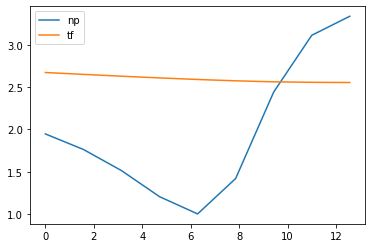

In [101]:
plt.plot(parameters,landscape[periods], label="np")
plt.plot(parameters,np.array(list(l.values()))/(dt*len(signals)),label="tf")
plt.legend()

Text(0, 0.5, '$L = \\frac{1}{2 T}(\\sum_t \\; |d\\vec{y}_t - C\\hat{x}_t dt|^2) \\sim \\dfrac{1}{2} (\\sum_t dW^2 + dW^2) \\sim 1$')

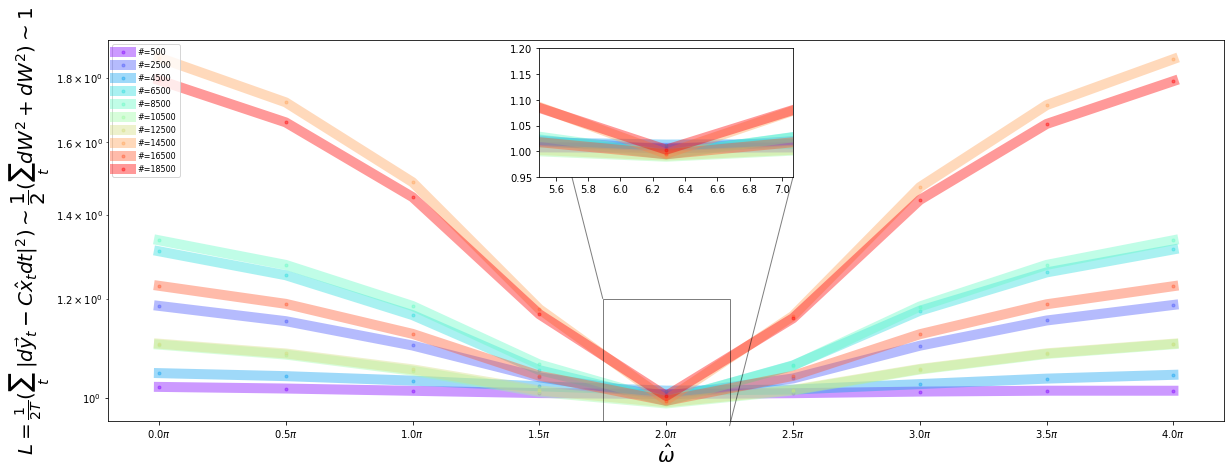

In [109]:
plt.figure(figsize=(20,7))

colors = plt.get_cmap("rainbow")
ax = plt.subplot2grid((1,1),(0,0))
axins = ax.inset_axes([2*np.pi - np.pi/2, 1.5, np.pi, .4],  transform=ax.transData)
#axins.set_xticks([])

for ind,i in enumerate(list(landscape.keys())):
    ax.plot(parameters,landscape[i],'.-', linewidth=10, alpha=0.4,color=colors(np.linspace(0,1,len(landscape)))[ind], label="#={}".format(i*ppp))
    ax.set_xticks(ticks=parameters)
    ax.set_xticklabels([str(np.round(p/np.pi,1))+r'$\pi$' for p in parameters])
    ax.set_yscale('log')
    axins.plot(parameters,landscape[i],'.-', linewidth=10, alpha=0.4,color=colors(np.linspace(0,1,len(landscape)))[ind])
    axins.set_xlim([2*np.pi - np.pi/4, 2*np.pi + np.pi/4])
    axins.set_ylim([.95,1.2])
    
plt.legend(prop={"size":8}, loc='upper left')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.xlabel(r'$\hat{\omega}$',size=20)
plt.ylabel(r'$L = \frac{1}{2 T}(\sum_t \; |d\vec{y}_t - C\hat{x}_t dt|^2) \sim \dfrac{1}{2} (\sum_t dW^2 + dW^2) \sim 1$', size=20)

# 